<a href="https://colab.research.google.com/github/mshilpaa/EVA4/blob/master/Session%2011/extras/s11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-sx633qwa
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-sx633qwa
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65099 sha256=59ea5d6373ffc25c1e3c654c62f3dc10a16a802ccf77b166a4f7b9d60fafcdaf
  Stored in directory: /tmp/pip-ephem-wheel-cache-9n7dx7ei/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.4.5
    Uninstalling albumentations-0.4.5:
      Successfully uninstalled albumentations-0.4.5


In [2]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [0]:
import sys
folder = '/content/gdrive/My Drive/Colab Notebooks/eva_files'
sys.path.append(folder)

In [5]:
%matplotlib inline
import torch
import data_loading
import show_images
import dnn_architecture
import train_and_test
import evaluate
import gradcam
import lr_finder

  pip install torch-lr-finder -v --global-option="amp"


In [6]:
import albumentations as A
train_aug = [A.RandomCrop(32, 32, always_apply=False, p=1.0),
             A.HorizontalFlip(),
             A.Cutout(num_holes=2, max_h_size=8,max_w_size = 8,p=1,fill_value=0.5*255), # after normalizing as mean is 0, thus fillvalue=0
             A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),]

classes, trainloader, testloader = data_loading.load(train_augmentation = train_aug,mode='default_test_aug')

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


shape: torch.Size([128, 3, 32, 32])
  cat truck truck   cat


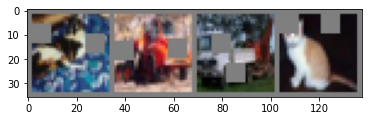

In [7]:
show_images.show_random_images(trainloader, classes)

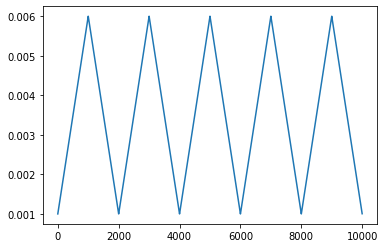

In [0]:
import matplotlib.pyplot as plt
import numpy as np
def CyclicLR(num_iterations,base_lr,max_lr,step_size):
  l_rate =[]
  for iteration in range(num_iterations):
    cycle = np.floor(1+iteration/(2*step_size))
    x = np.abs(iteration/step_size - 2*cycle + 1)
    lr = base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))
    l_rate.append(lr)
  plt.plot(list(range(num_iterations)),l_rate)

CyclicLR(num_iterations=10000,base_lr=0.001, max_lr=0.006,step_size=1000)

Write a code which

uses this new ResNet Architecture for Cifar10:

* PrepLayer - Conv 3x3 s1, p1) >> BN >> RELU [64k]

* Layer1 -
1. X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [128k]
2. R1 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [128k] 
(Conv-BN-ReLU-Conv-BN-ReLU)
3. Add(X, R1)

* Layer 2 -
1. Conv 3x3 [256k]
2. MaxPooling2D
3. BN
4. ReLU

* Layer 3 -
1. X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [512k]
2. R2 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [512k]
3. Add(X, R2)
* MaxPooling with Kernel Size 4
* FC Layer 
* SoftMax

* Uses One Cycle Policy such that:
1. Total Epochs = 24
2. Max at Epoch = 5
3. LRMIN = FIND
4. LRMAX = FIND
5. NO Annihilation
6. Uses this transform -RandomCrop 32, 32 (after padding of 4) >> FlipLR >> Followed by CutOut(8, 8)

Batch size = 512

Target Accuracy: 90%. 

The lesser the modular your code is (i.e. more the code you have written in your Colab file), less marks you'd get. 

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class New_Resnet(nn.Module):
    def __init__(self):
        super(New_Resnet,self).__init__()

        self.prepLayer = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=64,kernel_size=(3,3),bias=False,padding=1,stride=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                )
        
        self.cmbr_block1 = self._CMBR_Block(64,128)
        self.res_block1 = self._ResBlock(128,128)

        self.layer2 = self._CMBR_Block(128,256)

        self.cmbr_block2 = self._CMBR_Block(256,512)
        self.res_block2 = self._ResBlock(512,512)

        self.MP4x4 = nn.MaxPool2d(4,4)

        self.fc = nn.Conv2d(in_channels=512,out_channels=10,kernel_size=(1,1),bias=False,padding=0,stride=1)
    
    def _ResBlock(self,in_channels,out_channels):

        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=(3,3),bias=False,stride=1,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels,out_channels=out_channels,kernel_size=(3,3),bias=False,stride=1,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        
    def _CMBR_Block(self,in_channels,out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=(3,3),bias=False,padding=1,stride=1),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    def forward(self,x):
      # PrepLayer
      x = self.prepLayer(x)
      # Layer 1
      x = self.cmbr_block1(x)
      r1 = self.res_block1(x)
      x = x + r1
      # Layer 2
      x = self.layer2(x)
      # Layer 3
      x = self.cmbr_block2(x)
      r2 = self.res_block2(x)
      x = x + r2

      x = self.MP4x4(x)
      x = self.fc(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)


In [48]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = New_Resnet().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

range test for lr 0.1 - 0.0001

In [11]:
lrs = [0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,
      0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,
      0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9,weight_decay=0.0005)

for lr in lrs:
  optimizer.param_groups[0]['lr'] = lr
  print('LR:',optimizer.param_groups[0]['lr'])
  train_and_test.train(model, device, trainloader, optimizer, criterion, 0)
  train_and_test.test(model, device, criterion, testloader)
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  model = New_Resnet().to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9,weight_decay=0.0005)


  0%|          | 0/391 [00:00<?, ?it/s]

LR: 0.0001


Loss=1.569243311882019 Batch_id=390 Accuracy=34.26: 100%|██████████| 391/391 [00:20<00:00, 18.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0119, Accuracy: 4603/10000 (46.03%)

LR: 0.0002


Loss=1.4085056781768799 Batch_id=390 Accuracy=40.20: 100%|██████████| 391/391 [00:20<00:00, 19.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0107, Accuracy: 5109/10000 (51.09%)

LR: 0.0003


Loss=1.2542226314544678 Batch_id=390 Accuracy=42.52: 100%|██████████| 391/391 [00:20<00:00, 18.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0104, Accuracy: 5237/10000 (52.37%)

LR: 0.0004


Loss=1.275904655456543 Batch_id=390 Accuracy=43.75: 100%|██████████| 391/391 [00:20<00:00, 19.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0102, Accuracy: 5267/10000 (52.67%)

LR: 0.0005


Loss=1.082350730895996 Batch_id=390 Accuracy=45.67: 100%|██████████| 391/391 [00:20<00:00, 19.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0093, Accuracy: 5806/10000 (58.06%)

LR: 0.0006


Loss=1.0310128927230835 Batch_id=390 Accuracy=47.40: 100%|██████████| 391/391 [00:20<00:00, 18.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0089, Accuracy: 6019/10000 (60.19%)

LR: 0.0007


Loss=1.4212915897369385 Batch_id=390 Accuracy=47.17: 100%|██████████| 391/391 [00:20<00:00, 18.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0089, Accuracy: 5951/10000 (59.51%)

LR: 0.0008


Loss=1.214979887008667 Batch_id=390 Accuracy=47.51: 100%|██████████| 391/391 [00:20<00:00, 18.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 5832/10000 (58.32%)

LR: 0.0009


Loss=1.4703620672225952 Batch_id=390 Accuracy=49.11: 100%|██████████| 391/391 [00:20<00:00, 19.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0086, Accuracy: 6071/10000 (60.71%)

LR: 0.001


Loss=1.332137942314148 Batch_id=390 Accuracy=49.09: 100%|██████████| 391/391 [00:20<00:00, 18.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0089, Accuracy: 5967/10000 (59.67%)

LR: 0.002


Loss=1.2077630758285522 Batch_id=390 Accuracy=50.16: 100%|██████████| 391/391 [00:20<00:00, 19.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 6112/10000 (61.12%)

LR: 0.003


Loss=1.1313235759735107 Batch_id=390 Accuracy=52.21: 100%|██████████| 391/391 [00:20<00:00, 18.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0081, Accuracy: 6561/10000 (65.61%)

LR: 0.004


Loss=1.5788356065750122 Batch_id=390 Accuracy=48.75: 100%|██████████| 391/391 [00:20<00:00, 18.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0115, Accuracy: 5591/10000 (55.91%)

LR: 0.005


Loss=1.0492137670516968 Batch_id=390 Accuracy=48.08: 100%|██████████| 391/391 [00:20<00:00, 18.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0085, Accuracy: 6160/10000 (61.60%)

LR: 0.006


Loss=1.1827934980392456 Batch_id=390 Accuracy=46.03: 100%|██████████| 391/391 [00:20<00:00, 18.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0095, Accuracy: 5979/10000 (59.79%)

LR: 0.007


Loss=1.1767277717590332 Batch_id=390 Accuracy=46.56: 100%|██████████| 391/391 [00:20<00:00, 19.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0089, Accuracy: 6179/10000 (61.79%)

LR: 0.008


Loss=1.893949270248413 Batch_id=390 Accuracy=35.78: 100%|██████████| 391/391 [00:20<00:00, 18.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0117, Accuracy: 5062/10000 (50.62%)

LR: 0.009


Loss=1.693889856338501 Batch_id=390 Accuracy=30.56: 100%|██████████| 391/391 [00:20<00:00, 18.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0139, Accuracy: 4428/10000 (44.28%)

LR: 0.01


Loss=1.624837875366211 Batch_id=390 Accuracy=32.84: 100%|██████████| 391/391 [00:20<00:00, 19.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0113, Accuracy: 5145/10000 (51.45%)

LR: 0.02


Loss=2.126594066619873 Batch_id=390 Accuracy=22.40: 100%|██████████| 391/391 [00:20<00:00, 18.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0144, Accuracy: 4029/10000 (40.29%)

LR: 0.03


Loss=1.9300458431243896 Batch_id=390 Accuracy=20.45: 100%|██████████| 391/391 [00:20<00:00, 18.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 3561/10000 (35.61%)

LR: 0.04


Loss=1.9281120300292969 Batch_id=390 Accuracy=23.05: 100%|██████████| 391/391 [00:21<00:00, 18.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0139, Accuracy: 3731/10000 (37.31%)

LR: 0.05


Loss=1.9072519540786743 Batch_id=390 Accuracy=18.25: 100%|██████████| 391/391 [00:20<00:00, 18.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0146, Accuracy: 3377/10000 (33.77%)

LR: 0.06


Loss=2.293919324874878 Batch_id=390 Accuracy=10.55: 100%|██████████| 391/391 [00:20<00:00, 18.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 1148/10000 (11.48%)

LR: 0.07


Loss=1.9526081085205078 Batch_id=390 Accuracy=13.95: 100%|██████████| 391/391 [00:20<00:00, 18.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 2464/10000 (24.64%)

LR: 0.08


Loss=1.988994836807251 Batch_id=390 Accuracy=12.51: 100%|██████████| 391/391 [00:21<00:00, 18.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 1906/10000 (19.06%)

LR: 0.09


Loss=2.4197354316711426 Batch_id=390 Accuracy=11.71: 100%|██████████| 391/391 [00:20<00:00, 18.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 1608/10000 (16.08%)

LR: 0.1


Loss=2.2121810913085938 Batch_id=390 Accuracy=11.25: 100%|██████████| 391/391 [00:21<00:00, 18.51it/s]



Test set: Average loss: 0.0172, Accuracy: 1584/10000 (15.84%)



In [20]:
print('Train acc: ',max(train_and_test.train_acc_epoch_end),'LR: ',lrs[train_and_test.train_acc_epoch_end.index(max(train_and_test.train_acc_epoch_end))])
print('Test acc: ',max(train_and_test.test_acc),'LR: ',lrs[train_and_test.test_acc.index(max(train_and_test.test_acc))])

Train acc:  52.212 LR:  0.003
Test acc:  65.61 LR:  0.003


Text(0, 0.5, 'Train Accuracy')

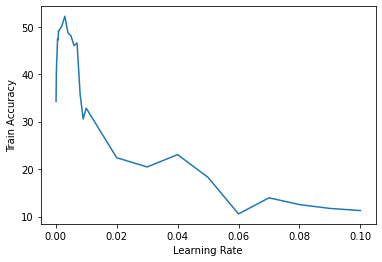

In [22]:
import matplotlib.pyplot as plt
plt.plot(lrs,train_and_test.train_acc_epoch_end)
plt.xlabel('Learning Rate')
plt.ylabel('Train Accuracy')

Text(0, 0.5, 'Test Accuracy')

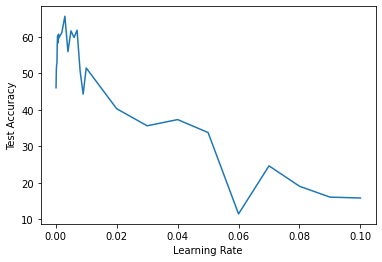

In [23]:
plt.plot(lrs,train_and_test.test_acc)
plt.xlabel('Learning Rate')
plt.ylabel('Test Accuracy')

In [24]:
optimizer.param_groups

[{'dampening': 0,
  'lr': 0.001,
  'momentum': 0.9,
  'nesterov': False,
  'params': [Parameter containing:
   tensor([[[[-0.1520, -0.1387,  0.0926],
             [ 0.0614,  0.0779,  0.1455],
             [-0.1655, -0.0207, -0.0948]],
   
            [[ 0.1616,  0.1011,  0.1880],
             [-0.1248,  0.0143,  0.0377],
             [-0.0230,  0.0904,  0.1185]],
   
            [[-0.1135, -0.1657, -0.0108],
             [-0.0343, -0.0078,  0.0944],
             [-0.0546, -0.1504,  0.0519]]],
   
   
           [[[ 0.0480,  0.0551,  0.0880],
             [ 0.1503, -0.1192,  0.0147],
             [ 0.0348,  0.0182, -0.1311]],
   
            [[-0.1015, -0.1203, -0.0037],
             [ 0.1821,  0.1252, -0.1662],
             [ 0.0411,  0.1395, -0.1108]],
   
            [[ 0.1763,  0.1153,  0.0086],
             [ 0.0762, -0.0391, -0.0281],
             [-0.1231, -0.1183,  0.0827]]],
   
   
           [[[ 0.1797, -0.1489,  0.0185],
             [-0.1587, -0.0682,  0.0240],
            

In [25]:
len(optimizer.param_groups)

1

In [32]:
def _format_param(name, optimizer, param):
        """Return correctly formatted lr/momentum for each param group."""
        if isinstance(param, (list, tuple)):
            if len(param) != len(optimizer.param_groups):
                raise ValueError("expected {} values for {}, got {}".format(
                    len(optimizer.param_groups), name, len(param)))
            return param
        else:
            return [param] * len(optimizer.param_groups)

max_lr=0.02
final_div_factor = 10000
div_factor = 10
max_lrs = _format_param('max_lr', optimizer, max_lr)
print("max_lrs",max_lrs)
for idx, group in enumerate(optimizer.param_groups):
  group['initial_lr'] = max_lrs[idx] / div_factor
  group['max_lr'] = max_lrs[idx]
  group['min_lr'] = group['initial_lr'] / final_div_factor
  print(idx)
  print(group)
print(optimizer.param_groups[0]['initial_lr'])

max_lrs [0.02]
0
{'params': [Parameter containing:
tensor([[[[-0.1520, -0.1387,  0.0926],
          [ 0.0614,  0.0779,  0.1455],
          [-0.1655, -0.0207, -0.0948]],

         [[ 0.1616,  0.1011,  0.1880],
          [-0.1248,  0.0143,  0.0377],
          [-0.0230,  0.0904,  0.1185]],

         [[-0.1135, -0.1657, -0.0108],
          [-0.0343, -0.0078,  0.0944],
          [-0.0546, -0.1504,  0.0519]]],


        [[[ 0.0480,  0.0551,  0.0880],
          [ 0.1503, -0.1192,  0.0147],
          [ 0.0348,  0.0182, -0.1311]],

         [[-0.1015, -0.1203, -0.0037],
          [ 0.1821,  0.1252, -0.1662],
          [ 0.0411,  0.1395, -0.1108]],

         [[ 0.1763,  0.1153,  0.0086],
          [ 0.0762, -0.0391, -0.0281],
          [-0.1231, -0.1183,  0.0827]]],


        [[[ 0.1797, -0.1489,  0.0185],
          [-0.1587, -0.0682,  0.0240],
          [ 0.0062, -0.0184, -0.0429]],

         [[ 0.1329,  0.1325,  0.1221],
          [ 0.0551,  0.0143,  0.1552],
          [-0.1308,  0.1476, -0.16

In [34]:
print(optimizer.param_groups[1]['initial_lr'])

IndexError: ignored

In [0]:
class OneCycleLR(_LRScheduler):
    r"""Sets the learning rate of each parameter group according to the
    1cycle learning rate policy. The 1cycle policy anneals the learning
    rate from an initial learning rate to some maximum learning rate and then
    from that maximum learning rate to some minimum learning rate much lower
    than the initial learning rate.
    This policy was initially described in the paper `Super-Convergence:
    Very Fast Training of Neural Networks Using Large Learning Rates`_.

    The 1cycle learning rate policy changes the learning rate after every batch.
    `step` should be called after a batch has been used for training.

    This scheduler is not chainable.

    Note also that the total number of steps in the cycle can be determined in one
    of two ways (listed in order of precedence):

    #. A value for total_steps is explicitly provided.
    #. A number of epochs (epochs) and a number of steps per epoch
       (steps_per_epoch) are provided.
       In this case, the number of total steps is inferred by
       total_steps = epochs * steps_per_epoch

    You must either provide a value for total_steps or provide a value for both
    epochs and steps_per_epoch.

    Args:
        optimizer (Optimizer): Wrapped optimizer.
        max_lr (float or list): Upper learning rate boundaries in the cycle
            for each parameter group.
        total_steps (int): The total number of steps in the cycle. Note that
            if a value is provided here, then it must be inferred by providing
            a value for epochs and steps_per_epoch.
            Default: None
        epochs (int): The number of epochs to train for. This is used along
            with steps_per_epoch in order to infer the total number of steps in the cycle
            if a value for total_steps is not provided.
            Default: None
        steps_per_epoch (int): The number of steps per epoch to train for. This is
            used along with epochs in order to infer the total number of steps in the
            cycle if a value for total_steps is not provided.
            Default: None
        pct_start (float): The percentage of the cycle (in number of steps) spent
            increasing the learning rate.
            Default: 0.3
        anneal_strategy (str): {'cos', 'linear'}
            Specifies the annealing strategy: "cos" for cosine annealing, "linear" for
            linear annealing.
            Default: 'cos'
        cycle_momentum (bool): If ``True``, momentum is cycled inversely
            to learning rate between 'base_momentum' and 'max_momentum'.
            Default: True
        base_momentum (float or list): Lower momentum boundaries in the cycle
            for each parameter group. Note that momentum is cycled inversely
            to learning rate; at the peak of a cycle, momentum is
            'base_momentum' and learning rate is 'max_lr'.
            Default: 0.85
        max_momentum (float or list): Upper momentum boundaries in the cycle
            for each parameter group. Functionally,
            it defines the cycle amplitude (max_momentum - base_momentum).
            Note that momentum is cycled inversely
            to learning rate; at the start of a cycle, momentum is 'max_momentum'
            and learning rate is 'base_lr'
            Default: 0.95
        div_factor (float): Determines the initial learning rate via
            initial_lr = max_lr/div_factor
            Default: 25
        final_div_factor (float): Determines the minimum learning rate via
            min_lr = initial_lr/final_div_factor
            Default: 1e4
        last_epoch (int): The index of the last batch. This parameter is used when
            resuming a training job. Since `step()` should be invoked after each
            batch instead of after each epoch, this number represents the total
            number of *batches* computed, not the total number of epochs computed.
            When last_epoch=-1, the schedule is started from the beginning.
            Default: -1

    Example:
        >>> data_loader = torch.utils.data.DataLoader(...)
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(data_loader), epochs=10)
        >>> for epoch in range(10):
        >>>     for batch in data_loader:
        >>>         train_batch(...)
        >>>         scheduler.step()


    .. _Super-Convergence\: Very Fast Training of Neural Networks Using Large Learning Rates:
        https://arxiv.org/abs/1708.07120
    """
    def __init__(self,
                 optimizer,
                 max_lr,
                 total_steps=None,
                 epochs=None,
                 steps_per_epoch=None,
                 pct_start=0.3,
                 anneal_strategy='cos',
                 cycle_momentum=True,
                 base_momentum=0.85,
                 max_momentum=0.95,
                 div_factor=25.,
                 final_div_factor=1e4,
                 last_epoch=-1):

        # Validate optimizer
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer

        # Validate total_steps
        if total_steps is None and epochs is None and steps_per_epoch is None:
            raise ValueError("You must define either total_steps OR (epochs AND steps_per_epoch)")
        elif total_steps is not None:
            if total_steps <= 0 or not isinstance(total_steps, int):
                raise ValueError("Expected non-negative integer total_steps, but got {}".format(total_steps))
            self.total_steps = total_steps
        else:
            if epochs <= 0 or not isinstance(epochs, int):
                raise ValueError("Expected non-negative integer epochs, but got {}".format(epochs))
            if steps_per_epoch <= 0 or not isinstance(steps_per_epoch, int):
                raise ValueError("Expected non-negative integer steps_per_epoch, but got {}".format(steps_per_epoch))
            self.total_steps = epochs * steps_per_epoch
        self.step_size_up = float(pct_start * self.total_steps) - 1
        self.step_size_down = float(self.total_steps - self.step_size_up) - 1

        # Validate pct_start
        if pct_start < 0 or pct_start > 1 or not isinstance(pct_start, float):
            raise ValueError("Expected float between 0 and 1 pct_start, but got {}".format(pct_start))

        # Validate anneal_strategy
        if anneal_strategy not in ['cos', 'linear']:
            raise ValueError("anneal_strategy must by one of 'cos' or 'linear', instead got {}".format(anneal_strategy))
        elif anneal_strategy == 'cos':
            self.anneal_func = self._annealing_cos
        elif anneal_strategy == 'linear':
            self.anneal_func = self._annealing_linear

        # Initialize learning rate variables
        max_lrs = self._format_param('max_lr', self.optimizer, max_lr)
        if last_epoch == -1:
            for idx, group in enumerate(self.optimizer.param_groups):
                group['initial_lr'] = max_lrs[idx] / div_factor
                group['max_lr'] = max_lrs[idx]
                group['min_lr'] = group['initial_lr'] / final_div_factor

        # Initialize momentum variables
        self.cycle_momentum = cycle_momentum
        if self.cycle_momentum:
            if 'momentum' not in self.optimizer.defaults and 'betas' not in self.optimizer.defaults:
                raise ValueError('optimizer must support momentum with `cycle_momentum` option enabled')
            self.use_beta1 = 'betas' in self.optimizer.defaults
            max_momentums = self._format_param('max_momentum', optimizer, max_momentum)
            base_momentums = self._format_param('base_momentum', optimizer, base_momentum)
            if last_epoch == -1:
                for m_momentum, b_momentum, group in zip(max_momentums, base_momentums, optimizer.param_groups):
                    if self.use_beta1:
                        _, beta2 = group['betas']
                        group['betas'] = (m_momentum, beta2)
                    else:
                        group['momentum'] = m_momentum
                    group['max_momentum'] = m_momentum
                    group['base_momentum'] = b_momentum

        super(OneCycleLR, self).__init__(optimizer, last_epoch)

    def _format_param(self, name, optimizer, param):
        """Return correctly formatted lr/momentum for each param group."""
        if isinstance(param, (list, tuple)):
            if len(param) != len(optimizer.param_groups):
                raise ValueError("expected {} values for {}, got {}".format(
                    len(optimizer.param_groups), name, len(param)))
            return param
        else:
            return [param] * len(optimizer.param_groups)

    def _annealing_cos(self, start, end, pct):
        "Cosine anneal from `start` to `end` as pct goes from 0.0 to 1.0."
        cos_out = math.cos(math.pi * pct) + 1
        return end + (start - end) / 2.0 * cos_out

    def _annealing_linear(self, start, end, pct):
        "Linearly anneal from `start` to `end` as pct goes from 0.0 to 1.0."
        return (end - start) * pct + start

    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", DeprecationWarning)

        lrs = []
        step_num = self.last_epoch

        if step_num > self.total_steps:
            raise ValueError("Tried to step {} times. The specified number of total steps is {}"
                             .format(step_num + 1, self.total_steps))

        for group in self.optimizer.param_groups:
            if step_num <= self.step_size_up:
                computed_lr = self.anneal_func(group['initial_lr'], group['max_lr'], step_num / self.step_size_up)
                if self.cycle_momentum:
                    computed_momentum = self.anneal_func(group['max_momentum'], group['base_momentum'],
                                                         step_num / self.step_size_up)
            else:
                down_step_num = step_num - self.step_size_up
                computed_lr = self.anneal_func(group['max_lr'], group['min_lr'], down_step_num / self.step_size_down)
                if self.cycle_momentum:
                    computed_momentum = self.anneal_func(group['base_momentum'], group['max_momentum'],
                                                         down_step_num / self.step_size_down)

            lrs.append(computed_lr)
            if self.cycle_momentum:
                if self.use_beta1:
                    _, beta2 = group['betas']
                    group['betas'] = (computed_momentum, beta2)
                else:
                    group['momentum'] = computed_momentum

        return lrs


In [0]:
lr = 0.003
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
max_lr = 0.003
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9,weight_decay=0.0005)
scheduler = OneCycleLR(optimizer, max_lr, total_steps=24, epochs=None, steps_per_epoch=None,
                       pct_start=0.21, anneal_strategy='linear', cycle_momentum=False, base_momentum=0.85,
                       max_momentum=0.95, div_factor=10.0, final_div_factor=10.0, last_epoch=-1)

In [50]:
EPOCHS = 24
l_rate = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1, 'LR:',optimizer.param_groups[0]['lr'])
    l_rate.append(optimizer.param_groups[0]['lr'])
    train_and_test.train(model, device, trainloader, optimizer, criterion, epoch)
    train_and_test.test(model, device, criterion, testloader)
    scheduler.step()

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.00030000000000000003


Loss=1.1332885026931763 Batch_id=390 Accuracy=43.28: 100%|██████████| 391/391 [00:20<00:00, 18.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0101, Accuracy: 5376/10000 (53.76%)

EPOCH: 2 LR: 0.0009683168316831684


Loss=0.8910887837409973 Batch_id=390 Accuracy=57.58: 100%|██████████| 391/391 [00:20<00:00, 18.79it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0077, Accuracy: 6593/10000 (65.93%)

EPOCH: 3 LR: 0.0016366336633663369


Loss=0.8344448208808899 Batch_id=390 Accuracy=66.49: 100%|██████████| 391/391 [00:20<00:00, 18.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 7023/10000 (70.23%)

EPOCH: 4 LR: 0.002304950495049505


Loss=0.7260974645614624 Batch_id=390 Accuracy=71.61: 100%|██████████| 391/391 [00:20<00:00, 18.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 7468/10000 (74.68%)

EPOCH: 5 LR: 0.0029732673267326734


Loss=0.6867616176605225 Batch_id=390 Accuracy=75.84: 100%|██████████| 391/391 [00:20<00:00, 18.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 7366/10000 (73.66%)

EPOCH: 6 LR: 0.0028496202531645572


Loss=0.7682235240936279 Batch_id=390 Accuracy=80.77: 100%|██████████| 391/391 [00:20<00:00, 18.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 7866/10000 (78.66%)

EPOCH: 7 LR: 0.002692974683544304


Loss=0.46973031759262085 Batch_id=390 Accuracy=83.57: 100%|██████████| 391/391 [00:20<00:00, 19.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8163/10000 (81.63%)

EPOCH: 8 LR: 0.0025363291139240507


Loss=0.44187507033348083 Batch_id=390 Accuracy=86.36: 100%|██████████| 391/391 [00:20<00:00, 18.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8358/10000 (83.58%)

EPOCH: 9 LR: 0.002379683544303798


Loss=0.26026010513305664 Batch_id=390 Accuracy=88.36: 100%|██████████| 391/391 [00:20<00:00, 18.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8411/10000 (84.11%)

EPOCH: 10 LR: 0.0022230379746835446


Loss=0.3660350441932678 Batch_id=390 Accuracy=90.07: 100%|██████████| 391/391 [00:20<00:00, 18.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8505/10000 (85.05%)

EPOCH: 11 LR: 0.0020663924050632913


Loss=0.18257170915603638 Batch_id=390 Accuracy=91.49: 100%|██████████| 391/391 [00:20<00:00, 18.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8469/10000 (84.69%)

EPOCH: 12 LR: 0.0019097468354430382


Loss=0.14107206463813782 Batch_id=390 Accuracy=92.92: 100%|██████████| 391/391 [00:20<00:00, 18.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8596/10000 (85.96%)

EPOCH: 13 LR: 0.001753101265822785


Loss=0.1095067635178566 Batch_id=390 Accuracy=94.23: 100%|██████████| 391/391 [00:20<00:00, 18.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8629/10000 (86.29%)

EPOCH: 14 LR: 0.0015964556962025317


Loss=0.14233514666557312 Batch_id=390 Accuracy=95.00: 100%|██████████| 391/391 [00:20<00:00, 18.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8747/10000 (87.47%)

EPOCH: 15 LR: 0.0014398101265822784


Loss=0.13421320915222168 Batch_id=390 Accuracy=96.14: 100%|██████████| 391/391 [00:20<00:00, 18.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8729/10000 (87.29%)

EPOCH: 16 LR: 0.0012831645569620252


Loss=0.13716323673725128 Batch_id=390 Accuracy=96.97: 100%|██████████| 391/391 [00:21<00:00, 18.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8722/10000 (87.22%)

EPOCH: 17 LR: 0.001126518987341772


Loss=0.09828563779592514 Batch_id=390 Accuracy=97.48: 100%|██████████| 391/391 [00:20<00:00, 18.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8776/10000 (87.76%)

EPOCH: 18 LR: 0.0009698734177215193


Loss=0.08819501847028732 Batch_id=390 Accuracy=97.86: 100%|██████████| 391/391 [00:20<00:00, 18.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8815/10000 (88.15%)

EPOCH: 19 LR: 0.000813227848101266


Loss=0.05952795222401619 Batch_id=390 Accuracy=98.39: 100%|██████████| 391/391 [00:20<00:00, 18.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8805/10000 (88.05%)

EPOCH: 20 LR: 0.0006565822784810127


Loss=0.12089518457651138 Batch_id=390 Accuracy=98.52: 100%|██████████| 391/391 [00:20<00:00, 18.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8832/10000 (88.32%)

EPOCH: 21 LR: 0.0004999367088607595


Loss=0.049762412905693054 Batch_id=390 Accuracy=98.77: 100%|██████████| 391/391 [00:20<00:00, 18.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8845/10000 (88.45%)

EPOCH: 22 LR: 0.0003432911392405066


Loss=0.0464128777384758 Batch_id=390 Accuracy=98.78: 100%|██████████| 391/391 [00:20<00:00, 18.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8868/10000 (88.68%)

EPOCH: 23 LR: 0.00018664556962025335


Loss=0.04604651778936386 Batch_id=390 Accuracy=99.04: 100%|██████████| 391/391 [00:20<00:00, 18.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8897/10000 (88.97%)

EPOCH: 24 LR: 3.000000000000008e-05


Loss=0.06920798122882843 Batch_id=390 Accuracy=99.05: 100%|██████████| 391/391 [00:20<00:00, 18.77it/s]



Test set: Average loss: 0.0029, Accuracy: 8882/10000 (88.82%)



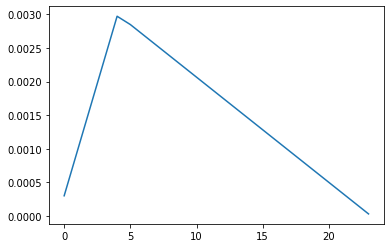

In [51]:
plt.plot(l_rate)

In [44]:
lr = 0.003
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
max_lr = 0.003
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9,weight_decay=0.0005)
scheduler = OneCycleLR(optimizer, max_lr, total_steps=24, epochs=None, steps_per_epoch=None,
                       pct_start=0.21, anneal_strategy='cos', cycle_momentum=False, base_momentum=0.85,
                       max_momentum=0.95, div_factor=25.0, final_div_factor=10000.0, last_epoch=-1)

EPOCHS = 25
l_rate = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1, 'LR:',optimizer.param_groups[0]['lr'])
    l_rate.append(optimizer.param_groups[0]['lr'])
    train_and_test.train(model, device, trainloader, optimizer, criterion, epoch)
    train_and_test.test(model, device, criterion, testloader)
    scheduler.step()

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.00011999999999999988


Loss=1.5383408069610596 Batch_id=390 Accuracy=36.83: 100%|██████████| 391/391 [00:22<00:00, 17.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0114, Accuracy: 4786/10000 (47.86%)

EPOCH: 2 LR: 0.0005338790916275898


Loss=1.134059190750122 Batch_id=390 Accuracy=53.99: 100%|██████████| 391/391 [00:22<00:00, 17.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0093, Accuracy: 5783/10000 (57.83%)

EPOCH: 3 LR: 0.0015376053908346945


Loss=0.8980819582939148 Batch_id=390 Accuracy=62.61: 100%|██████████| 391/391 [00:22<00:00, 17.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 6931/10000 (69.31%)

EPOCH: 4 LR: 0.0025542048296233154


Loss=0.47000980377197266 Batch_id=390 Accuracy=70.32: 100%|██████████| 391/391 [00:22<00:00, 17.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 7177/10000 (71.77%)

EPOCH: 5 LR: 0.002999303446500463


Loss=0.47050532698631287 Batch_id=390 Accuracy=75.56: 100%|██████████| 391/391 [00:21<00:00, 18.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7765/10000 (77.65%)

EPOCH: 6 LR: 0.0029810630886524486


Loss=0.5821719765663147 Batch_id=390 Accuracy=79.62: 100%|██████████| 391/391 [00:21<00:00, 18.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 8026/10000 (80.26%)

EPOCH: 7 LR: 0.002921589495900446


Loss=0.4865858554840088 Batch_id=390 Accuracy=82.69: 100%|██████████| 391/391 [00:21<00:00, 18.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8201/10000 (82.01%)

EPOCH: 8 LR: 0.002823175397065313


Loss=0.3739716708660126 Batch_id=390 Accuracy=85.35: 100%|██████████| 391/391 [00:21<00:00, 18.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8219/10000 (82.19%)

EPOCH: 9 LR: 0.002688516585131005


Loss=0.3853529095649719 Batch_id=390 Accuracy=87.40: 100%|██████████| 391/391 [00:21<00:00, 18.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8554/10000 (85.54%)

EPOCH: 10 LR: 0.0025213016807803003


Loss=0.2843354344367981 Batch_id=390 Accuracy=89.64: 100%|██████████| 391/391 [00:21<00:00, 18.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8563/10000 (85.63%)

EPOCH: 11 LR: 0.002326111092423142


Loss=0.27586567401885986 Batch_id=390 Accuracy=91.16: 100%|██████████| 391/391 [00:21<00:00, 18.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8338/10000 (83.38%)

EPOCH: 12 LR: 0.002108291548067566


Loss=0.22533011436462402 Batch_id=390 Accuracy=92.77: 100%|██████████| 391/391 [00:21<00:00, 18.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8670/10000 (86.70%)

EPOCH: 13 LR: 0.0018738096358995374


Loss=0.08052829653024673 Batch_id=390 Accuracy=94.20: 100%|██████████| 391/391 [00:21<00:00, 18.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8753/10000 (87.53%)

EPOCH: 14 LR: 0.0016290883654387182


Loss=0.08226507902145386 Batch_id=390 Accuracy=95.13: 100%|██████████| 391/391 [00:21<00:00, 18.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8756/10000 (87.56%)

EPOCH: 15 LR: 0.0013808312262434301


Loss=0.14094367623329163 Batch_id=390 Accuracy=96.42: 100%|██████████| 391/391 [00:21<00:00, 18.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8749/10000 (87.49%)

EPOCH: 16 LR: 0.0011358385636095303


Loss=0.15765126049518585 Batch_id=390 Accuracy=97.16: 100%|██████████| 391/391 [00:21<00:00, 18.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8808/10000 (88.08%)

EPOCH: 17 LR: 0.0009008213011634747


Loss=0.0852380245923996 Batch_id=390 Accuracy=97.58: 100%|██████████| 391/391 [00:20<00:00, 18.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8870/10000 (88.70%)

EPOCH: 18 LR: 0.0006822171129246319


Loss=0.1516604870557785 Batch_id=390 Accuracy=98.08: 100%|██████████| 391/391 [00:21<00:00, 18.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8916/10000 (89.16%)

EPOCH: 19 LR: 0.000486014080315204


Loss=0.07048213481903076 Batch_id=390 Accuracy=98.44: 100%|██████████| 391/391 [00:20<00:00, 18.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8931/10000 (89.31%)

EPOCH: 20 LR: 0.00031758666456584747


Loss=0.01495092548429966 Batch_id=390 Accuracy=98.47: 100%|██████████| 391/391 [00:20<00:00, 18.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8948/10000 (89.48%)

EPOCH: 21 LR: 0.0001815484876174944


Loss=0.04449812322854996 Batch_id=390 Accuracy=98.78: 100%|██████████| 391/391 [00:20<00:00, 18.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8955/10000 (89.55%)

EPOCH: 22 LR: 8.162595419577061e-05


Loss=0.028489336371421814 Batch_id=390 Accuracy=98.74: 100%|██████████| 391/391 [00:20<00:00, 18.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8950/10000 (89.50%)

EPOCH: 23 LR: 2.055617684578616e-05


Loss=0.052419088780879974 Batch_id=390 Accuracy=98.92: 100%|██████████| 391/391 [00:20<00:00, 18.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8949/10000 (89.49%)

EPOCH: 24 LR: 1.2e-08


Loss=0.02483847551047802 Batch_id=390 Accuracy=98.83: 100%|██████████| 391/391 [00:20<00:00, 18.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8950/10000 (89.50%)

EPOCH: 25 LR: 2.0556176845785995e-05


Loss=0.06902532279491425 Batch_id=390 Accuracy=98.89: 100%|██████████| 391/391 [00:20<00:00, 18.69it/s]



Test set: Average loss: 0.0028, Accuracy: 8949/10000 (89.49%)



UnboundLocalError: ignored

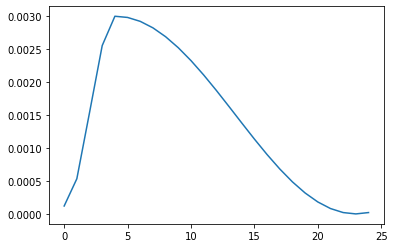

In [46]:
plt.plot(l_rate)

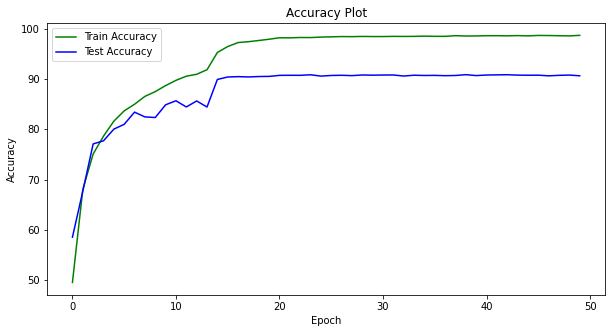

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
ax.plot(train_and_test.train_acc_epoch_end,color = 'g',label="Train Accuracy")
ax.plot(train_and_test.test_acc,color = 'b',label="Test Accuracy")
ax.set(title="Accuracy Plot", xlabel="Epoch", ylabel="Accuracy")
ax.legend()
plt.show()

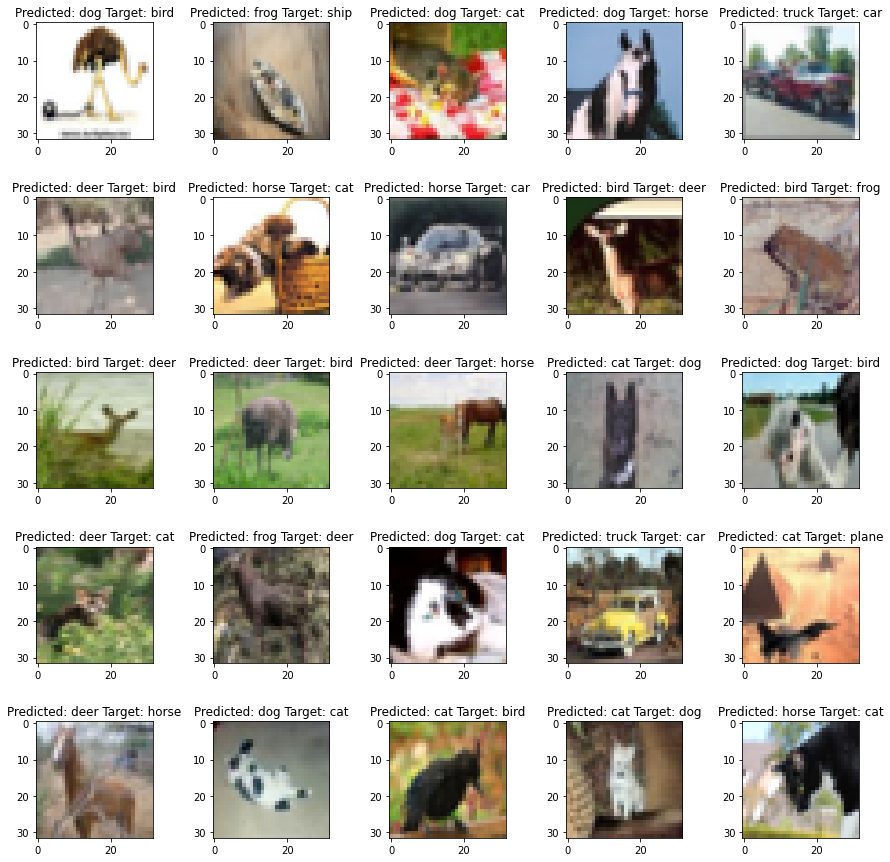

In [0]:
misclassify = show_images.show_misclassified_images(model, device, testloader,classes,num=25)

In [0]:
len(misclassify[1])

937

GroundTruth:    car   dog   cat   dog   cat
Predicted:    car   dog   dog   dog   cat


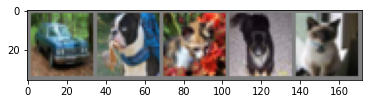

In [0]:
evaluate.show_predicted_actual(model, device, testloader, classes)

In [0]:
evaluate.evaluate_accuracy(model, device, testloader)

Accuracy of the network on the 10000 test images: 90 %


In [0]:
evaluate.evaluate_classwise_accuracy(model, device, classes, testloader)

Accuracy of plane : 94 %
Accuracy of   car : 93 %
Accuracy of  bird : 92 %
Accuracy of   cat : 86 %
Accuracy of  deer : 85 %
Accuracy of   dog : 77 %
Accuracy of  frog : 88 %
Accuracy of horse : 97 %
Accuracy of  ship : 80 %
Accuracy of truck : 93 %


In [0]:
import torch
from torch.nn import functional as F
import warnings

class GradCam(object):

	def __init__(self, model, target_layers, num_classes):
		super(GradCam, self).__init__()
		self.model = model
		self.target_layers = target_layers
		self.num_classes = num_classes
		self.device = next(model.parameters()).device

		self.activations_map = {}
		self.gradients_map = {}

		self.model.eval()
		self.register_hooks()

	def register_hooks(self):
		def _wrap_forward_hook(layer_name):
			def _forward_hook(module, input, output):
				self.activations_map[layer_name] = output.detach()
			return _forward_hook

		def _wrap_backward_hook(layer_name):
			def _backward_hook(module, grad_out, grad_in):
				self.gradients_map[layer_name] = grad_out[0].detach()
			return _backward_hook

		for name, module in self.model.named_modules():
			if name in self.target_layers:
				module.register_forward_hook(_wrap_forward_hook(name))
				module.register_backward_hook(_wrap_backward_hook(name))

	def make_one_hots(self, target_class=None):
		one_hots = torch.zeros_like(self.output)
		if target_class:
			ids = torch.LongTensor([[target_class]] * self.batch_size).to(self.device)
			one_hots.scatter_(1,ids,1.0)
		else:
			one_hots = torch.zeros((self.batch_size, self.num_classes)).to(self.device)
			for i in range(len(self.pred)):
			  one_hots[i][self.pred[i][0]] = 1.0
		return one_hots

	def forward(self, data):
		self.batch_size, self.img_ch, self.img_h, self.img_w = data.shape
		data = data.to(self.device)
		self.output = self.model(data)
		self.pred = self.output.argmax(dim=1, keepdim=True)

	def backward(self, target_class=None):
		one_hots = self.make_one_hots(target_class)
		self.model.zero_grad()
		self.output.backward(gradient=one_hots, retain_graph=True)

	def __call__(self, data, target_layers, target_class=None,name=None):
		self.forward(data)
		self.backward(target_class)

		output = self.output
		saliency_maps = {}
		for target_layer in target_layers:
			activations = self.activations_map[target_layer]	#[64, 512, 4, 4]
			grads = self.gradients_map[target_layer]	#[64, 512, 4, 4]
			weights = F.adaptive_avg_pool2d(grads, 1)	#[64, 512, 1, 1]

			saliency_map = torch.mul(activations, weights).sum(dim=1, keepdim=True)	
			saliency_map = F.relu(saliency_map)	#[64,1,4,4]
			saliency_map = F.interpolate(saliency_map, (self.img_h, self.img_w),
				mode="bilinear", align_corners=False)	#[64,1,32,32]

			saliency_map = saliency_map.view(self.batch_size, -1)
			saliency_map -= saliency_map.min(dim=1, keepdim=True)[0]
			saliency_map /= saliency_map.max(dim=1, keepdim=True)[0]
			saliency_map = saliency_map.view(self.batch_size, 1,
											self.img_h, self.img_w)
			saliency_maps[target_layer] = saliency_map
    
		if name =='misclassify':
			return saliency_maps
		else:
			return saliency_maps, self.pred

import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np


def denormalize(tensor, mean=[0.4914, 0.4822, 0.4465],
						std=[0.2023, 0.1994, 0.2010]):
	single_img = False
	if tensor.ndimension() == 3:
		single_img = True
		tensor = tensor[None,:,:,:]

	if not tensor.ndimension() == 4:
	    raise TypeError('tensor should be 4D')

	mean = torch.FloatTensor(mean).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
	std = torch.FloatTensor(std).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
	ret = tensor.mul(std).add(mean)
	return ret[0] if single_img else ret

class VisualizeCam(object):

	def __init__(self, model, classes, target_layers):
		super(VisualizeCam, self).__init__()
		self.model = model
		self.classes = classes
		self.target_layers = target_layers
		self.device = next(model.parameters()).device

		self.gcam = GradCam(model, target_layers, len(classes))
		
	def visualize_cam(self, mask, img):
	    heatmap = (255 * mask.squeeze()).type(torch.uint8).cpu().numpy()
	    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
	    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
	    b, g, r = heatmap.split(1)
	    heatmap = torch.cat([r, g, b])
	    
	    result = heatmap+img.cpu()
	    result = result.div(result.max()).squeeze()
	    return heatmap, result

	def plot_heatmaps(self, img_data, pred_class,target_class, img_name):
		warnings.filterwarnings("ignore")
		fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(10, 4),
			subplot_kw={'xticks': [], 'yticks': []})
		fig.suptitle('GradCam at different conv layers for the class: Predicted: %s, Target: %s \n' % 
		(	pred_class,target_class))

		for ax, data in zip(axs.flat, img_data):
			img = data["img"]
			npimg = img.cpu().numpy()
			ax.imshow(np.transpose(npimg, (1, 2, 0)))
			ax.set_title("%s" % (data["label"]))

		plt.savefig('/content/gdrive/My Drive/Colab Notebooks/eva_files/images/'+img_name)


	def __call__(self, images, target_layers,target_class, target_inds=None, metric="",pred=None,num=25,name=None):
		if name=='misclassify':
			masks_map = self.gcam(images, target_layers, target_inds,name)
		else:
			masks_map, pred = self.gcam(images, target_layers, target_inds,name)
		for i in range(min(len(images),num)):
			img = images[i]
			results_data = [{
				"img": denormalize(img),
				"label": "Result:"
			}]
			heatmaps_data = [{
				"img": denormalize(img),
				"label": "Heatmap:"
			}]
			for layer in target_layers:
				mask = masks_map[layer][i]
				heatmap, result = self.visualize_cam(mask, img)
				results_data.append({
					"img": result,
					"label": layer
				})
				heatmaps_data.append({
					"img": heatmap,
					"label": layer
				})
			if name=='misclassify':
				pred_class = pred[i]
			else:
				pred_class = self.classes[pred[i][0]]
			fname = "gradcam_%s.png" % (i)
			self.plot_heatmaps(results_data+heatmaps_data, pred_class,target_class[i], fname)

In [0]:
max(train_and_test.train_acc)

100.0

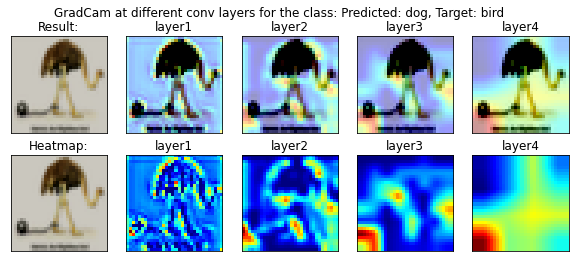

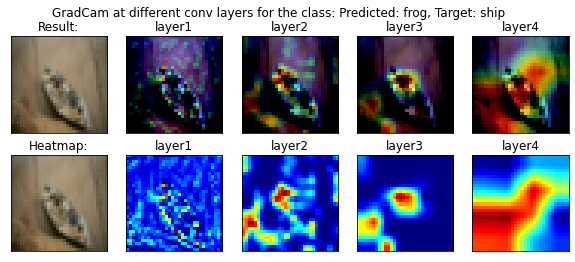

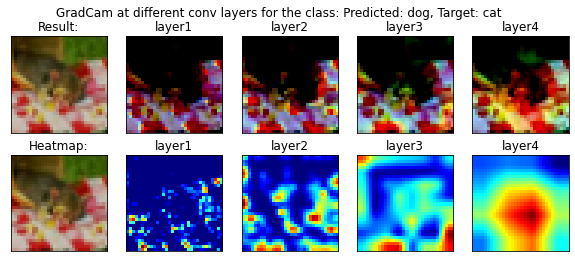

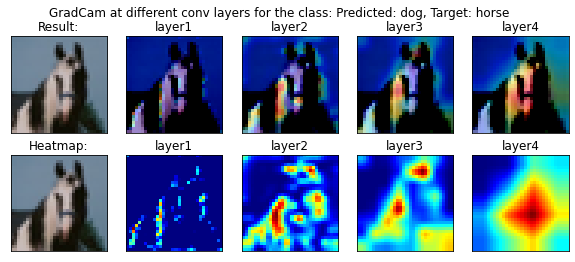

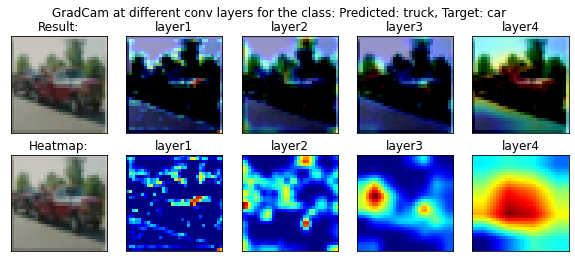

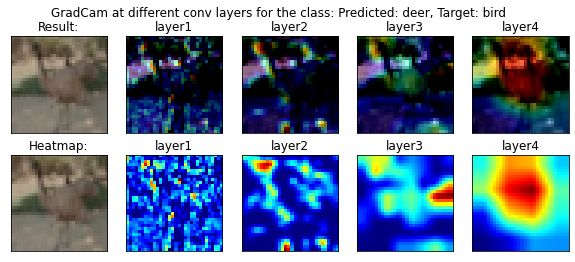

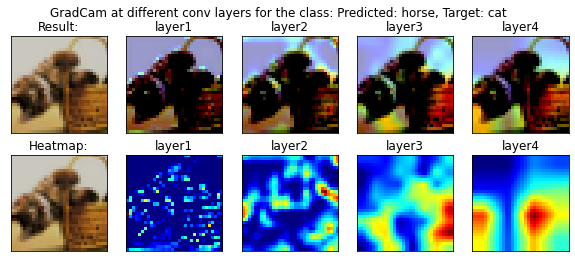

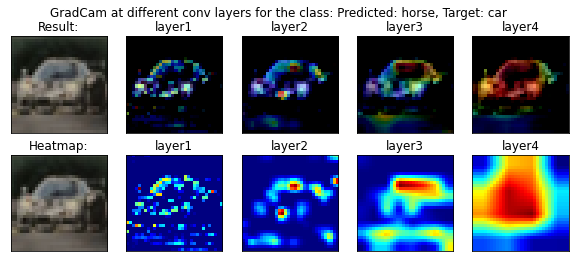

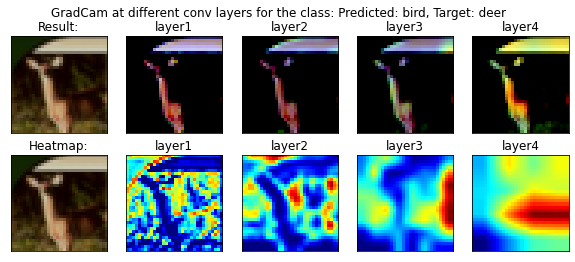

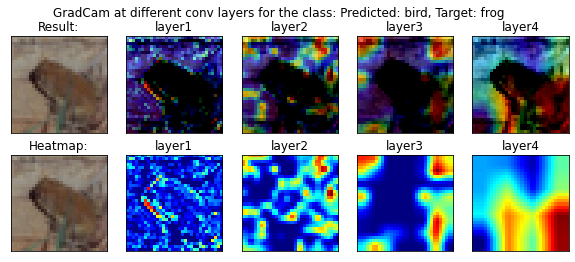

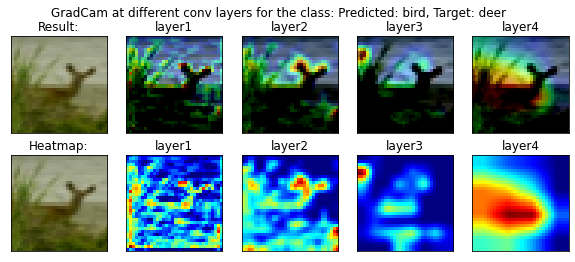

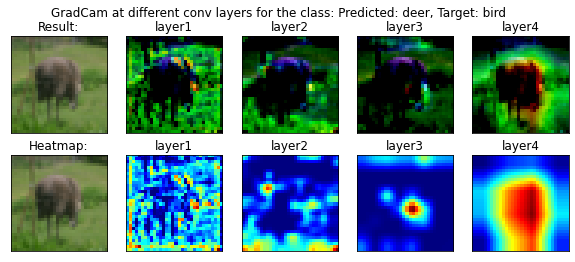

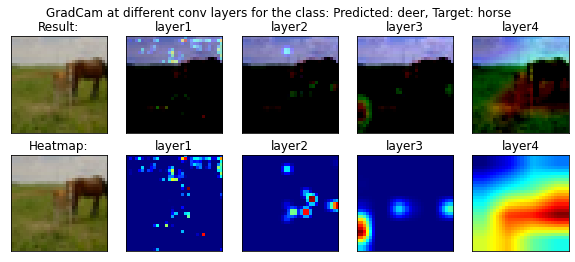

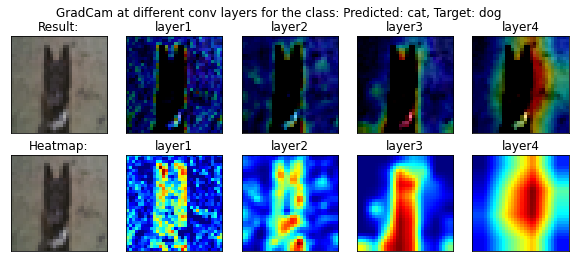

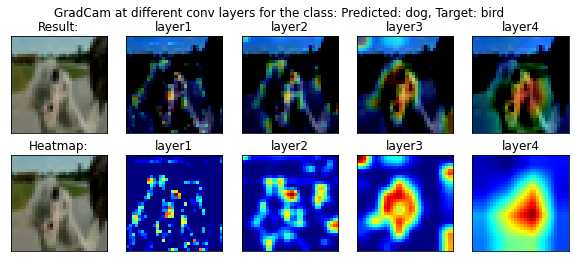

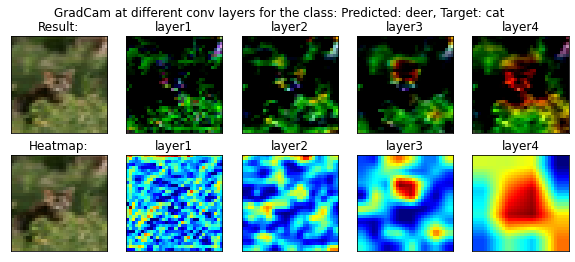

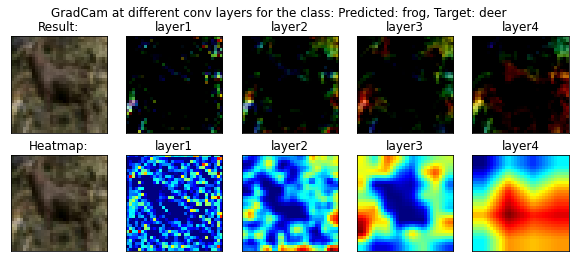

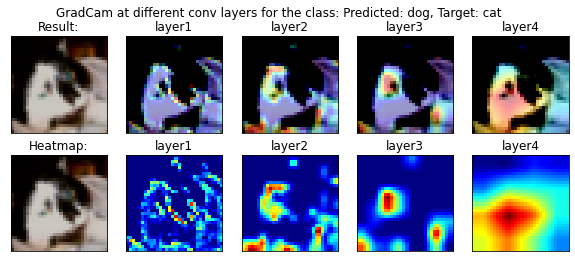

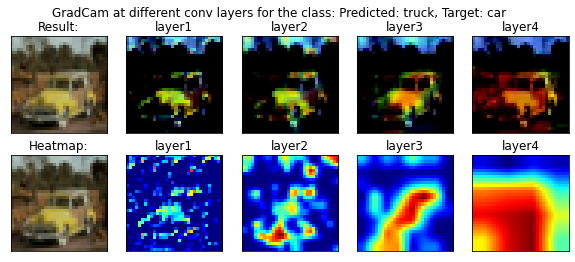

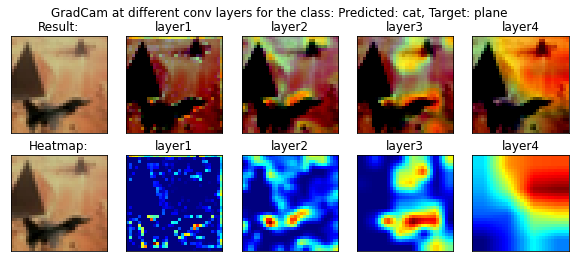

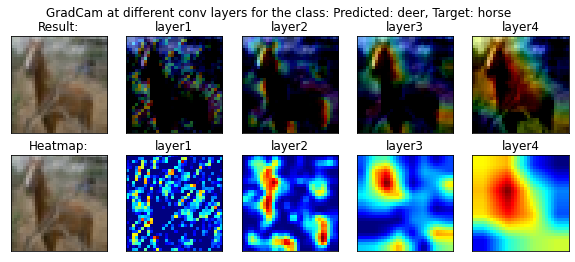

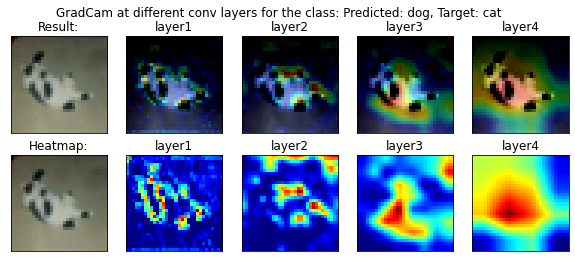

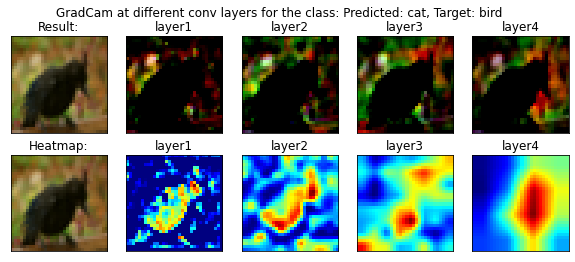

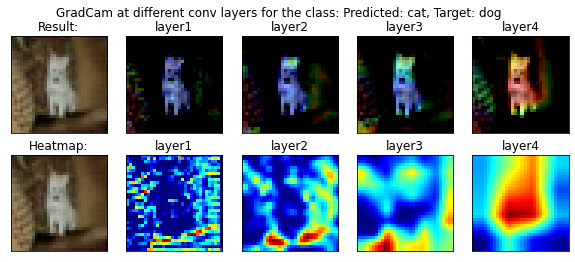

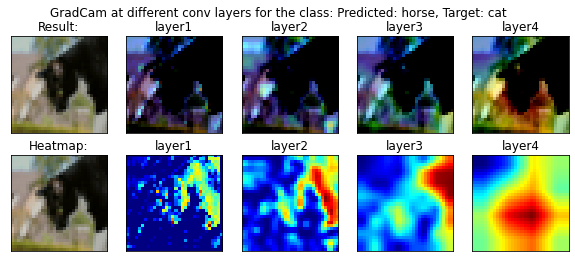

In [0]:
images=[]

for i in range(25):
  images.append(misclassify[0][i]*2-0.5)

target_layers = ["layer1","layer2","layer3","layer4"]
gradcam = VisualizeCam(model,classes, target_layers)
gradcam(torch.stack(images), target_layers,target_class=misclassify[2],pred=misclassify[1],num=25,name='misclassify')